---
# 1.Setup

Environment Variables

In [27]:
!pip install -U langgraph langchain-google-genai langsmith

In [1]:
from google.colab import userdata
import os
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = userdata.get('Smith2')
GEMINI_API_KEY= userdata.get('gemini')

---
# 2.Download Database

Download the Data from public api

In [2]:
import requests

url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    # Open a local file in binary write mode
    with open("chinook.db", "wb") as file:
        # Write the content of the response (the file) to the local file
        file.write(response.content)
    print("File downloaded and saved as Chinook.db")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded and saved as Chinook.db


Check sample of Data in the db

In [3]:
import sqlite3

conn = sqlite3.connect("chinook.db")
cursor = conn.cursor()

# Fetch all results
cursor.execute("SELECT * FROM Artist LIMIT 10;").fetchall()

[(1, 'AC/DC'),
 (2, 'Accept'),
 (3, 'Aerosmith'),
 (4, 'Alanis Morissette'),
 (5, 'Alice In Chains'),
 (6, 'Antônio Carlos Jobim'),
 (7, 'Apocalyptica'),
 (8, 'Audioslave'),
 (9, 'BackBeat'),
 (10, 'Billy Cobham')]

---
# 3.Create Agent

## 3a. Refund Processing Agent

### 3a1. Define SQL Functions
- Find the purchase record in db
- Delete the invoice & invoice line to prcoess refund

In [4]:
import sqlite3

def _lookup(
    customer_first_name: str,
    customer_last_name: str,
    customer_phone: str,
    track_name: str | None,
    album_title: str | None,
    artist_name: str | None,
    purchase_date_iso_8601: str | None,
) -> list[dict]:
    """Find all of the Invoice Line IDs in the Chinook DB for the given filters.

    Returns:
        a list of dictionaries that contain keys: {
            'invoice_line_id',
            'track_name',
            'artist_name',
            'purchase_date',
            'quantity_purchased',
            'price_per_unit'
        }
    """

    # Connect to the database
    conn = sqlite3.connect("chinook.db")
    cursor = conn.cursor()

    # Base query joining all necessary tables
    query = """
    SELECT
        il.InvoiceLineId,
        t.Name as track_name,
        art.Name as artist_name,
        i.InvoiceDate as purchase_date,
        il.Quantity as quantity_purchased,
        il.UnitPrice as price_per_unit
    FROM InvoiceLine il
    JOIN Invoice i ON il.InvoiceId = i.InvoiceId
    JOIN Customer c ON i.CustomerId = c.CustomerId
    JOIN Track t ON il.TrackId = t.TrackId
    JOIN Album alb ON t.AlbumId = alb.AlbumId
    JOIN Artist art ON alb.ArtistId = art.ArtistId
    WHERE c.FirstName = ?
    AND c.LastName = ?
    AND c.Phone = ?
    """

    # Parameters for the query
    params = [customer_first_name, customer_last_name, customer_phone]

    # Add optional filters
    if track_name:
        query += " AND t.Name = ?"
        params.append(track_name)

    if album_title:
        query += " AND alb.Title = ?"
        params.append(album_title)

    if artist_name:
        query += " AND art.Name = ?"
        params.append(artist_name)

    if purchase_date_iso_8601:
        query += " AND date(i.InvoiceDate) = date(?)"
        params.append(purchase_date_iso_8601)

    # Execute query
    cursor.execute(query, params)

    # Fetch results
    results = cursor.fetchall()

    # Convert results to list of dictionaries
    output = []
    for row in results:
        output.append(
            {
                "invoice_line_id": row[0],
                "track_name": row[1],
                "artist_name": row[2],
                "purchase_date": row[3],
                "quantity_purchased": row[4],
                "price_per_unit": row[5],
            }
        )

    # Close connection
    conn.close()

    return output

def _refund(invoice_id: int | None, invoice_line_ids: list[int] | None, mock: bool = False) -> float:
    """Given an Invoice ID and/or Invoice Line IDs, delete the relevant Invoice/InvoiceLine records in the Chinook DB.

    Args:
        invoice_id: The Invoice to delete.
        invoice_line_ids: The Invoice Lines to delete.
        mock: If True, do not actually delete the specified Invoice/Invoice Lines. Used for testing purposes.

    Returns:
        float: The total dollar amount that was deleted (or mock deleted).
    """

    if invoice_id is None and invoice_line_ids is None:
        return 0.0

    # Connect to the Chinook database
    conn = sqlite3.connect("chinook.db")
    cursor = conn.cursor()

    total_refund = 0.0

    try:
        # If invoice_id is provided, delete entire invoice and its lines
        if invoice_id is not None:
            # First get the total amount for the invoice
            cursor.execute(
                """
                SELECT Total
                FROM Invoice
                WHERE InvoiceId = ?
            """,
                (invoice_id,),
            )

            result = cursor.fetchone()
            if result:
                total_refund += result[0]

            # Delete invoice lines first (due to foreign key constraints)
            if not mock:
                cursor.execute(
                    """
                    DELETE FROM InvoiceLine
                    WHERE InvoiceId = ?
                """,
                    (invoice_id,),
                )

                # Then delete the invoice
                cursor.execute(
                    """
                    DELETE FROM Invoice
                    WHERE InvoiceId = ?
                """,
                    (invoice_id,),
                )

        # If specific invoice lines are provided
        if invoice_line_ids is not None:
            # Get the total amount for the specified invoice lines
            placeholders = ",".join(["?" for _ in invoice_line_ids])
            cursor.execute(
                f"""
                SELECT SUM(UnitPrice * Quantity)
                FROM InvoiceLine
                WHERE InvoiceLineId IN ({placeholders})
            """,
                invoice_line_ids,
            )

            result = cursor.fetchone()
            if result and result[0]:
                total_refund += result[0]

            if not mock:
                # Delete the specified invoice lines
                cursor.execute(
                    f"""
                    DELETE FROM InvoiceLine
                    WHERE InvoiceLineId IN ({placeholders})
                """,
                    invoice_line_ids,
                )

        # Commit the changes
        conn.commit()

    except sqlite3.Error as e:
        # Roll back in case of error
        conn.rollback()
        raise e

    finally:
        # Close the connection
        conn.close()

    return float(total_refund)

### 3a2. Define Graph
Extract info frm conver --> Route 2 path
refund / lookup / response path

In [5]:
from typing import Literal
import json

from langchain.chat_models import init_chat_model
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, StateGraph
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.types import Command, interrupt
from tabulate import tabulate
from typing_extensions import Annotated, TypedDict

# Graph state.
class State(TypedDict):
    """Agent state."""
    messages: Annotated[list[AnyMessage], add_messages]
    followup: str | None

    invoice_id: int | None
    invoice_line_ids: list[int] | None
    customer_first_name: str | None
    customer_last_name: str | None
    customer_phone: str | None
    track_name: str | None
    album_title: str | None
    artist_name: str | None
    purchase_date_iso_8601: str | None

# Instructions for extracting the user/purchase info from the conversation.
gather_info_instructions = """You are managing an online music store that sells song tracks. \
Customers can buy multiple tracks at a time and these purchases are recorded in a database as \
an Invoice per purchase and an associated set of Invoice Lines for each purchased track.

Your task is to help customers who would like a refund for one or more of the tracks they've \
purchased. In order for you to be able refund them, the customer must specify the Invoice ID \
to get a refund on all the tracks they bought in a single transaction, or one or more Invoice \
Line IDs if they would like refunds on individual tracks.

Often a user will not know the specific Invoice ID(s) or Invoice Line ID(s) for which they \
would like a refund. In this case you can help them look up their invoices by asking them to \
specify:
- Required: Their first name, last name, and phone number.
- Optionally: The track name, artist name, album name, or purchase date.

If the customer has not specified the required information (either Invoice/Invoice Line IDs \
or first name, last name, phone) then please ask them to specify it."""

# Extraction schema, mirrors the graph state.
class PurchaseInformation(TypedDict):
    """All of the known information about the invoice / invoice lines the customer would like refunded. Do not make up values, leave fields as null if you don't know their value."""

    invoice_id: int | None
    invoice_line_ids: list[int] | None
    customer_first_name: str | None
    customer_last_name: str | None
    customer_phone: str | None
    track_name: str | None
    album_title: str | None
    artist_name: str | None
    purchase_date_iso_8601: str | None
    followup: Annotated[
        str | None,
        ...,
        "If the user hasn't enough identifying information, please tell them what the required information is and ask them to specify it.",
    ]

# Model for performing extraction.
info_llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai",google_api_key=GEMINI_API_KEY).with_structured_output(
    PurchaseInformation, method="json_schema", include_raw=True
)

# Graph node for extracting user info and routing to lookup/refund/END.
async def gather_info(state: State) -> Command[Literal["lookup", "refund", END]]:
    info = await info_llm.ainvoke(
        [
            {"role": "system", "content": gather_info_instructions},
            *state["messages"],
        ]
    )
    parsed = info["parsed"]
    if any(parsed[k] for k in ("invoice_id", "invoice_line_ids")):
        goto = "refund"
    elif all(
        parsed[k]
        for k in ("customer_first_name", "customer_last_name", "customer_phone")
    ):
        goto = "lookup"
    else:
        goto = END
    update = {"messages": [info["raw"]], **parsed}
    return Command(update=update, goto=goto)

# Graph node for executing the refund.
# Note that here we inspect the runtime config for an "env" variable.
# If "env" is set to "test", then we don't actually delete any rows from our database.
# This will become important when we're running our evaluations.
def refund(state: State, config: RunnableConfig) -> dict:
    # Whether to mock the deletion. True if the configurable var 'env' is set to 'test'.
    mock = config.get("configurable", {}).get("env", "prod") == "test"
    refunded = _refund(
        invoice_id=state["invoice_id"], invoice_line_ids=state["invoice_line_ids"], mock=mock
    )
    response = f"You have been refunded a total of: ${refunded:.2f}. Is there anything else I can help with?"
    return {
        "messages": [{"role": "assistant", "content": response}],
        "followup": response,
    }

# Graph node for looking up the users purchases
def lookup(state: State) -> dict:
    args = (
        state[k]
        for k in (
            "customer_first_name",
            "customer_last_name",
            "customer_phone",
            "track_name",
            "album_title",
            "artist_name",
            "purchase_date_iso_8601",
        )
    )
    results = _lookup(*args)
    if not results:
        response = "We did not find any purchases associated with the information you've provided. Are you sure you've entered all of your information correctly?"
        followup = response
    else:
        response = f"Which of the following purchases would you like to be refunded for?\n\n```json{json.dumps(results, indent=2)}\n```"
        followup = f"Which of the following purchases would you like to be refunded for?\n\n{tabulate(results, headers='keys')}"
    return {
        "messages": [{"role": "assistant", "content": response}],
        "followup": followup,
        "invoice_line_ids": [res["invoice_line_id"] for res in results],
    }

# Building our graph
graph_builder = StateGraph(State)

graph_builder.add_node(gather_info)
graph_builder.add_node(refund)
graph_builder.add_node(lookup)

graph_builder.set_entry_point("gather_info")
graph_builder.add_edge("lookup", END)
graph_builder.add_edge("refund", END)

refund_graph = graph_builder.compile()

view graph

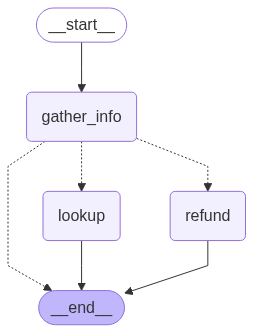

In [6]:
# Assumes you're in an interactive Python environment
from IPython.display import Image, display

display(Image(refund_graph.get_graph(xray=True).draw_mermaid_png()))

## 3b. Lookup Agent

In [7]:
from langchain.embeddings import init_embeddings
from langchain_core.tools import tool
from langchain_core.vectorstores import InMemoryVectorStore
from langgraph.prebuilt import create_react_agent

# Our SQL queries will only work if we filter on the exact string values that are in the DB.
# To ensure this, we'll create vectorstore indexes for all of the artists, tracks and albums
# ahead of time and use those to disambiguate the user input. E.g. if a user searches for
# songs by "prince" and our DB records the artist as "Prince", ideally when we query our
# artist vectorstore for "prince" we'll get back the value "Prince", which we can then
# use in our SQL queries.
def index_fields() -> tuple[InMemoryVectorStore, InMemoryVectorStore, InMemoryVectorStore]:
    """Create an index for all artists, an index for all albums, and an index for all songs."""
    try:
        # Connect to the chinook database
        conn = sqlite3.connect("chinook.db")
        cursor = conn.cursor()

        # Fetch all results
        tracks = cursor.execute("SELECT Name FROM Track").fetchall()
        artists = cursor.execute("SELECT Name FROM Artist").fetchall()
        albums = cursor.execute("SELECT Title FROM Album").fetchall()
    finally:
        # Close the connection
        if conn:
            conn.close()

    embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001", google_api_key=GEMINI_API_KEY)

    track_store = InMemoryVectorStore(embeddings)
    artist_store = InMemoryVectorStore(embeddings)
    album_store = InMemoryVectorStore(embeddings)

    track_store.add_texts([t[0] for t in tracks])
    artist_store.add_texts([a[0] for a in artists])
    album_store.add_texts([a[0] for a in albums])
    return track_store, artist_store, album_store

track_store, artist_store, album_store = index_fields()

# Agent tools
@tool
def lookup_track(
    track_name: str | None = None,
    album_title: str | None = None,
    artist_name: str | None = None,
) -> list[dict]:
    """Lookup a track in Chinook DB based on identifying information about.

    Returns:
        a list of dictionaries per matching track that contain keys {'track_name', 'artist_name', 'album_name'}
    """
    conn = sqlite3.connect("chinook.db")
    cursor = conn.cursor()

    query = """
    SELECT DISTINCT t.Name as track_name, ar.Name as artist_name, al.Title as album_name
    FROM Track t
    JOIN Album al ON t.AlbumId = al.AlbumId
    JOIN Artist ar ON al.ArtistId = ar.ArtistId
    WHERE 1=1
    """
    params = []

    if track_name:
        track_name = track_store.similarity_search(track_name, k=1)[0].page_content
        query += " AND t.Name LIKE ?"
        params.append(f"%{track_name}%")
    if album_title:
        album_title = album_store.similarity_search(album_title, k=1)[0].page_content
        query += " AND al.Title LIKE ?"
        params.append(f"%{album_title}%")
    if artist_name:
        artist_name = artist_store.similarity_search(artist_name, k=1)[0].page_content
        query += " AND ar.Name LIKE ?"
        params.append(f"%{artist_name}%")

    cursor.execute(query, params)
    results = cursor.fetchall()

    tracks = [
        {"track_name": row[0], "artist_name": row[1], "album_name": row[2]}
        for row in results
    ]

    conn.close()
    return tracks

@tool
def lookup_album(
    track_name: str | None = None,
    album_title: str | None = None,
    artist_name: str | None = None,
) -> list[dict]:
    """Lookup an album in Chinook DB based on identifying information about.

    Returns:
        a list of dictionaries per matching album that contain keys {'album_name', 'artist_name'}
    """
    conn = sqlite3.connect("chinook.db")
    cursor = conn.cursor()

    query = """
    SELECT DISTINCT al.Title as album_name, ar.Name as artist_name
    FROM Album al
    JOIN Artist ar ON al.ArtistId = ar.ArtistId
    LEFT JOIN Track t ON t.AlbumId = al.AlbumId
    WHERE 1=1
    """
    params = []

    if track_name:
        query += " AND t.Name LIKE ?"
        params.append(f"%{track_name}%")
    if album_title:
        query += " AND al.Title LIKE ?"
        params.append(f"%{album_title}%")
    if artist_name:
        query += " AND ar.Name LIKE ?"
        params.append(f"%{artist_name}%")

    cursor.execute(query, params)
    results = cursor.fetchall()

    albums = [{"album_name": row[0], "artist_name": row[1]} for row in results]

    conn.close()
    return albums

@tool
def lookup_artist(
    track_name: str | None = None,
    album_title: str | None = None,
    artist_name: str | None = None,
) -> list[str]:
    """Lookup an album in Chinook DB based on identifying information about.

    Returns:
        a list of matching artist names
    """
    conn = sqlite3.connect("chinook.db")
    cursor = conn.cursor()

    query = """
    SELECT DISTINCT ar.Name as artist_name
    FROM Artist ar
    LEFT JOIN Album al ON al.ArtistId = ar.ArtistId
    LEFT JOIN Track t ON t.AlbumId = al.AlbumId
    WHERE 1=1
    """
    params = []

    if track_name:
        query += " AND t.Name LIKE ?"
        params.append(f"%{track_name}%")
    if album_title:
        query += " AND al.Title LIKE ?"
        params.append(f"%{album_title}%")
    if artist_name:
        query += " AND ar.Name LIKE ?"
        params.append(f"%{artist_name}%")

    cursor.execute(query, params)
    results = cursor.fetchall()

    artists = [row[0] for row in results]

    conn.close()
    return artists

# Agent model
qa_llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai",google_api_key=GEMINI_API_KEY)
# The prebuilt ReACT agent only expects State to have a 'messages' key, so the
# state we defined for the refund agent can also be passed to our lookup agent.
qa_graph = create_react_agent(qa_llm, [lookup_track, lookup_artist, lookup_album])

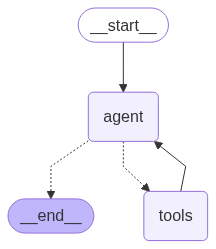

In [8]:
display(Image(qa_graph.get_graph(xray=True).draw_mermaid_png()))

## 3c. Parent Agent

Intent based routing

In [9]:
# Schema for routing user intent.
# We'll use structured outputs to enforce that the model returns only
# the desired output.
class UserIntent(TypedDict):
    """The user's current intent in the conversation"""

    intent: Literal["refund", "question_answering"]

# Routing model with structured output
router_llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai",google_api_key=GEMINI_API_KEY).with_structured_output(
    UserIntent, method="json_schema", strict=True
)

# Instructions for routing.
route_instructions = """You are managing an online music store that sells song tracks. \
You can help customers in two types of ways: (1) answering general questions about \
tracks sold at your store, (2) helping them get a refund on a purhcase they made at your store.

Based on the following conversation, determine if the user is currently seeking general \
information about song tracks or if they are trying to refund a specific purchase.

Return 'refund' if they are trying to get a refund and 'question_answering' if they are \
asking a general music question. Do NOT return anything else. Do NOT try to respond to \
the user.
"""

# Node for routing.
async def intent_classifier(
    state: State,
) -> Command[Literal["refund_agent", "question_answering_agent"]]:
    response = router_llm.invoke(
        [{"role": "system", "content": route_instructions}, *state["messages"]]
    )
    return Command(goto=response["intent"] + "_agent")

# Node for making sure the 'followup' key is set before our agent run completes.
def compile_followup(state: State) -> dict:
    """Set the followup to be the last message if it hasn't explicitly been set."""
    if not state.get("followup"):
        return {"followup": state["messages"][-1].content}
    return {}

# Agent definition
graph_builder = StateGraph(State)
graph_builder.add_node(intent_classifier)
# Since all of our subagents have compatible state,
# we can add them as nodes directly.
graph_builder.add_node("refund_agent", refund_graph)
graph_builder.add_node("question_answering_agent", qa_graph)
graph_builder.add_node(compile_followup)

graph_builder.set_entry_point("intent_classifier")
graph_builder.add_edge("refund_agent", "compile_followup")
graph_builder.add_edge("question_answering_agent", "compile_followup")
graph_builder.add_edge("compile_followup", END)

graph = graph_builder.compile()

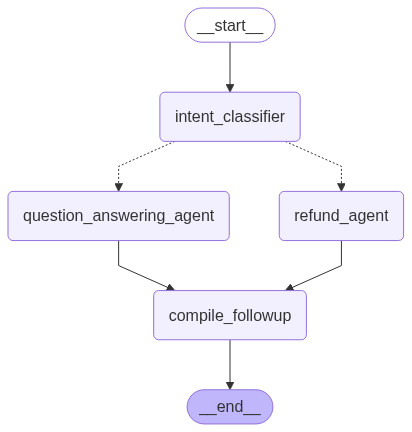

In [10]:
display(Image(graph.get_graph().draw_mermaid_png()))

## Try out

In [11]:
# Lookup

state = await graph.ainvoke(
    {"messages": [{"role": "user", "content": "what james brown songs do you have"}]}
)
print(state["followup"])

Here are the James Brown songs: Please Please Please, Think, Night Train, Out Of Sight, Papa's Got A Brand New Bag Pt.1, I Got You (I Feel Good), It's A Man's Man's Man's World, Cold Sweat, Say It Loud, I'm Black And I'm Proud Pt.1, Get Up (I Feel Like Being A) Sex Machine, Hey America, Make It Funky Pt.1, I'm A Greedy Man Pt.1, Get On The Good Foot, Get Up Offa That Thing, It's Too Funky In Here, Living In America, I'm Real, Hot Pants Pt.1, Soul Power (Live).


### Note : Need to Understand Why, retry with different models for different task and comparision
!!!! 2.5 pro was failing, 2.0 flash seems right choice

In [12]:
# Refun request
state = await graph.ainvoke({"messages": [
    {
        "role": "user",
        "content": "my name is Aaron Mitchell and my number is +1 (204) 452-6452. I bought some songs by Led Zeppelin that i'd like refunded",
    }
]})
print(state["followup"])

Which of the following purchases would you like to be refunded for?

  invoice_line_id  track_name                        artist_name    purchase_date          quantity_purchased    price_per_unit
-----------------  --------------------------------  -------------  -------------------  --------------------  ----------------
              267  How Many More Times               Led Zeppelin   2009-08-06 00:00:00                     1              0.99
              268  What Is And What Should Never Be  Led Zeppelin   2009-08-06 00:00:00                     1              0.99


---
# 4.Evaluation

## 4a. Final Response Evaluator

### Create Dataset...
...to eval : Final Response + Trajectory

In [13]:
from langsmith import Client

client = Client()

# Create a dataset
examples = [
    {
        "inputs": {
            "question": "How many songs do you have by James Brown",
        },
        "outputs": {
            "response": "We have 20 songs by James Brown",
            "trajectory": ["question_answering_agent", "lookup_track"]
        }
    },
    {
        "inputs": {
            "question": "My name is Aaron Mitchell and I'd like a refund.",
        },
        "outputs": {
            "response": "I need some more information to help you with the refund. Please specify your phone number, the invoice ID, or the line item IDs for the purchase you'd like refunded.",
            "trajectory": ["refund_agent"],
        }
    },
    {
        "inputs": {
            "question": "My name is Aaron Mitchell and I'd like a refund on my Led Zeppelin purchases. My number is +1 (204) 452-6452",
        },
        "outputs": {
            "response": 'Which of the following purchases would you like to be refunded for?\n\n  invoice_line_id  track_name                        artist_name    purchase_date          quantity_purchased    price_per_unit\n-----------------  --------------------------------  -------------  -------------------  --------------------  ----------------\n              267  How Many More Times               Led Zeppelin   2009-08-06 00:00:00                     1              0.99\n              268  What Is And What Should Never Be  Led Zeppelin   2009-08-06 00:00:00                     1              0.99',
            "trajectory": ["refund_agent", "lookup"],
        },
    },
    {
        "inputs": {
            "question": "Who recorded Wish You Were Here again? What other albums of there's do you have?",
        },
        "outputs": {
            "response": "Wish You Were Here is an album by Pink Floyd",
            "trajectory": ["question_answering_agent", "lookup_album"],
        },
    },
    {
        "inputs": {
            "question": "I want a full refund for invoice 237",
        },
        "outputs": {
            "response": "You have been refunded $0.99.",
            "trajectory": ["refund_agent", "refund"],
        }
    },
]

dataset_name = "Chinook Customer Service Bot_E2E"

if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    client.create_examples(
        dataset_id=dataset.id,
        examples=examples
    )

### Create LLM-as-a-judge evaluator

In [15]:
# LLM-as-judge instructions
grader_instructions = """You are a teacher grading a quiz.

You will be given a QUESTION, the GROUND TRUTH (correct) RESPONSE, and the STUDENT RESPONSE.

Here is the grade criteria to follow:
(1) Grade the student responses based ONLY on their factual accuracy relative to the ground truth answer.
(2) Ensure that the student response does not contain any conflicting statements.
(3) It is OK if the student response contains more information than the ground truth response, as long as it is factually accurate relative to the  ground truth response.

Correctness:
True means that the student's response meets all of the criteria.
False means that the student's response does not meet all of the criteria.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct."""

# LLM-as-judge output schema
class Grade(TypedDict):
    """Compare the expected and actual answers and grade the actual answer."""
    reasoning: Annotated[str, ..., "Explain your reasoning for whether the actual response is correct or not."]
    is_correct: Annotated[bool, ..., "True if the student response is mostly or exactly correct, otherwise False."]

# Judge LLM
grader_llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai",google_api_key=GEMINI_API_KEY, temperature=1).with_structured_output(Grade, method="json_schema", strict=True)

# Evaluator function
async def final_answer_correct(inputs: dict, outputs: dict, reference_outputs: dict) -> bool:
    """Evaluate if the final response is equivalent to reference response."""

    # Note that we assume the outputs has a 'response' dictionary. We'll need to make sure
    # that the target function we define includes this key.
    user = f"""QUESTION: {inputs['question']}
    GROUND TRUTH RESPONSE: {reference_outputs['response']}
    STUDENT RESPONSE: {outputs['response']}"""

    grade = await grader_llm.ainvoke([{"role": "system", "content": grader_instructions}, {"role": "user", "content": user}])
    return grade["is_correct"]

### Define Target Function & Run Exp


In [16]:
# Target function
async def run_graph(inputs: dict) -> dict:
    """Run graph and track the trajectory it takes along with the final response."""
    result = await graph.ainvoke({"messages": [
        { "role": "user", "content": inputs['question']},
    ]}, config={"env": "test"})
    return {"response": result["followup"]}

# Evaluation job and results
experiment_results = await client.aevaluate(
    run_graph,
    data=dataset_name,
    evaluators=[final_answer_correct],
    experiment_prefix="sql-agent-gpt4o-e2e",
    num_repetitions=1,
    max_concurrency=4,
)
experiment_results.to_pandas()

View the evaluation results for experiment: 'sql-agent-gpt4o-e2e-708e4ef9' at:
https://smith.langchain.com/o/ef9e87ab-1348-4c3e-9139-19b869acd75b/datasets/50a9413a-36b8-4324-a126-0c7e83299d61/compare?selectedSessions=cfa214cf-125d-435c-bd6e-c562996bf271




0it [00:00, ?it/s]

,inputs.question,outputs.response,error,reference.response,reference.trajectory,feedback.final_answer_correct,execution_time,example_id,id
0,My name is Aaron Mitchell and I'd like a refun...,Which of the following purchases would you lik...,None,Which of the following purchases would you lik...,"[refund_agent, lookup]",True,3.799265,06b638ef-17ef-481d-86c5-f74a9085fff1,5d95dc00-4434-4c90-8736-63713053ec98
1,Who recorded Wish You Were Here again? What ot...,"I am sorry, I cannot fulfill this request. The...",None,Wish You Were Here is an album by Pink Floyd,"[question_answering_agent, lookup_album]",False,3.731829,06d03660-e8ff-4437-99af-c1dcfcc40df5,4d3346c9-6219-46a4-9697-73a2f78ffaf8
2,My name is Aaron Mitchell and I'd like a refund.,"To locate your purchase, I also require your p...",None,I need some more information to help you with ...,[refund_agent],True,2.580333,47e267e6-6e9a-4290-a727-ebeb24e664ec,a31c1624-8b1c-4273-8338-fe74c35017a3
3,I want a full refund for invoice 237,You have been refunded a total of: $0.99. Is t...,None,You have been refunded $0.99.,"[refund_agent, refund]",True,3.814403,3ac6d13e-d88d-42b5-82ad-9415d414d97f,6086baf2-31ae-4c89-883b-283ff01c8ce7
4,How many songs do you have by James Brown,I cannot answer this question directly. The av...,None,We have 20 songs by James Brown,"[question_answering_agent, lookup_track]",False,1.360492,55a2d30a-17e0-4e5f-aaa6-2996f61b51ea,94f725b6-15ae-4340-b43f-360bed29f927


##4b. Trajectory Evaluator

### Create Trajectory Evaluator
% of expected path completed

In [17]:
def trajectory_subsequence(outputs: dict, reference_outputs: dict) -> float:
    """Check how many of the desired steps the agent took."""
    if len(reference_outputs['trajectory']) > len(outputs['trajectory']):
        return False

    i = j = 0
    while i < len(reference_outputs['trajectory']) and j < len(outputs['trajectory']):
        if reference_outputs['trajectory'][i] == outputs['trajectory'][j]:
            i += 1
        j += 1

    return i / len(reference_outputs['trajectory'])

### Define Target Function & Run Exp

In [19]:
async def run_graph(inputs: dict) -> dict:
    """Run graph and track the trajectory it takes along with the final response."""
    trajectory = []
    # Set subgraph=True to stream events from subgraphs of the main graph: https://langchain-ai.github.io/langgraph/how-tos/streaming-subgraphs/
    # Set stream_mode="debug" to stream all possible events: https://langchain-ai.github.io/langgraph/concepts/streaming
    async for namespace, chunk in graph.astream({"messages": [
            {
                "role": "user",
                "content": inputs['question'],
            }
        ]}, subgraphs=True, stream_mode="debug"):
        # Event type for entering a node
        if chunk['type'] == 'task':
            # Record the node name
            trajectory.append(chunk['payload']['name'])
            # Given how we defined our dataset, we also need to track when specific tools are
            # called by our question answering ReACT agent. These tool calls can be found
            # when the ToolsNode (named "tools") is invoked by looking at the AIMessage.tool_calls
            # of the latest input message.
            if chunk['payload']['name'] == 'tools' and chunk['type'] == 'task':
                for tc in chunk['payload']['input']['messages'][-1].tool_calls:
                    trajectory.append(tc['name'])

    return {"trajectory": trajectory}

experiment_results = await client.aevaluate(
    run_graph,
    data=dataset_name,
    evaluators=[trajectory_subsequence],
    experiment_prefix="sql-agent-gpt4o-trajectory",
    num_repetitions=1,
    max_concurrency=4,
)
experiment_results.to_pandas()

View the evaluation results for experiment: 'sql-agent-gpt4o-trajectory-e80bae44' at:
https://smith.langchain.com/o/ef9e87ab-1348-4c3e-9139-19b869acd75b/datasets/50a9413a-36b8-4324-a126-0c7e83299d61/compare?selectedSessions=f85238e9-c575-4fc1-b5af-64274c1629d8




0it [00:00, ?it/s]

ERROR:langsmith.evaluation._arunner:Error running target function: list indices must be integers or slices, not str
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/langsmith/evaluation/_arunner.py", line 1262, in _aforward
    await fn(*args, langsmith_extra=langsmith_extra)
  File "/tmp/ipython-input-19-797130621.py", line 21, in run_graph
    for tc in chunk['payload']['input']['messages'][-1].tool_calls:
              ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
TypeError: list indices must be integers or slices, not str


,inputs.question,outputs.output,error,reference.response,reference.trajectory,feedback.wrapper,execution_time,example_id,id,outputs.trajectory,feedback.trajectory_subsequence
0,Who recorded Wish You Were Here again? What ot...,NaN,TypeError('list indices must be integers or sl...,Wish You Were Here is an album by Pink Floyd,"[question_answering_agent, lookup_album]",NaN,3.235045,06d03660-e8ff-4437-99af-c1dcfcc40df5,77ab9b2a-11fd-4c63-9616-549a8b36f874,NaN,NaN
1,My name is Aaron Mitchell and I'd like a refund.,NaN,None,I need some more information to help you with ...,[refund_agent],NaN,3.245586,47e267e6-6e9a-4290-a727-ebeb24e664ec,14ddf8cd-1cb9-478d-8e45-c55d37484f38,"[intent_classifier, refund_agent, gather_info,...",1.0
2,My name is Aaron Mitchell and I'd like a refun...,NaN,None,Which of the following purchases would you lik...,"[refund_agent, lookup]",NaN,4.359175,06b638ef-17ef-481d-86c5-f74a9085fff1,0ab0ea07-affe-499a-bc36-3b689f7bd3b1,"[intent_classifier, refund_agent, gather_info,...",1.0
3,I want a full refund for invoice 237,NaN,None,You have been refunded $0.99.,"[refund_agent, refund]",NaN,4.355009,3ac6d13e-d88d-42b5-82ad-9415d414d97f,44b852ed-0fd7-4536-b0c7-a8a86694e747,"[intent_classifier, refund_agent, gather_info,...",1.0
4,How many songs do you have by James Brown,NaN,None,We have 20 songs by James Brown,"[question_answering_agent, lookup_track]",NaN,1.224086,55a2d30a-17e0-4e5f-aaa6-2996f61b51ea,27781ee7-79ed-4177-b693-8e1f866d8a2f,"[intent_classifier, question_answering_agent, ...",0.5


## 4c. Single Step Evaluators
### Intent Clasfn Evaluator (here)

### Create Dt, Ev, Def TF, Run Ex
Create Dataset, Create Evaluator, Define Target Function, Run Exp

In [20]:
# Create dataset
examples = [
    {
        "inputs": {"messages": [{"role": "user", "content": "i bought some tracks recently and i dont like them"}]},
        "outputs": {"route": "refund_agent"},
    },
    {
        "inputs": {"messages": [{"role": "user", "content": "I was thinking of purchasing some Rolling Stones tunes, any recommendations?"}]},
        "outputs": {"route": "question_answering_agent"},
    },
    {
        "inputs": {"messages": [{"role": "user", "content": "i want a refund on purchase 237"}, {"role": "assistant", "content": "I've refunded you a total of $1.98. How else can I help you today?"}, {"role": "user", "content": "did prince release any albums in 2000?"}]},
        "outputs": {"route": "question_answering_agent"},
    },
    {
        "inputs": {"messages": [{"role": "user", "content": "i purchased a cover of Yesterday recently but can't remember who it was by, which versions of it do you have?"}]},
        "outputs": {"route": "question_answering_agent"},
    },
]

dataset_name = "Chinook Customer Service Bot: Intent Classifier"
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    client.create_examples(
        dataset_id=dataset.id,
        examples=examples
    )

# Evaluator
def correct(outputs: dict, reference_outputs: dict) -> bool:
    """Check if the agent chose the correct route."""
    return outputs["route"] == reference_outputs["route"]

# Target function for running the relevant step
async def run_intent_classifier(inputs: dict) -> dict:
    # Note that we can access and run the intent_classifier node of our graph directly.
    command = await graph.nodes['intent_classifier'].ainvoke(inputs)
    return {"route": command.goto}

# Run evaluation
experiment_results = await client.aevaluate(
    run_intent_classifier,
    data=dataset_name,
    evaluators=[correct],
    experiment_prefix="sql-agent-gpt4o-intent-classifier",
    max_concurrency=4,
)

View the evaluation results for experiment: 'sql-agent-gpt4o-intent-classifier-01c9f283' at:
https://smith.langchain.com/o/ef9e87ab-1348-4c3e-9139-19b869acd75b/datasets/f5929810-c253-4826-b131-408436e33457/compare?selectedSessions=57ad17b1-7b1c-46db-b3c4-e787a6182f72




0it [00:00, ?it/s]

---
# *SQL data Fetch*

In [ ]:
import sqlite3
from tabulate import tabulate

def fetch_data_and_display(db_name: str, query: str, title: str):
    """
    Fetches data from a SQLite database using the given query and displays it in a table.

    Args:
        db_name: The name of the SQLite database file.
        query: The SQL query to execute.
        title: A title to display before the table.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        cursor = conn.cursor()
        cursor.execute(query)
        results = cursor.fetchall()

        print(f"### {title}\n") # Added title
        if results:
            # Get column names
            column_names = [description[0] for description in cursor.description]
            # Display results in a table
            print(tabulate(results, headers=column_names, tablefmt="grid"))
        else:
            print("No data found for the given query.")

    except sqlite3.Error as e:
        print(f"Database error: {e}")
    finally:
        if conn:
            conn.close()

# Fetch the first 10 entries from the 'Customer' table including the Phone number
fetch_data_and_display("chinook.db", "SELECT CustomerId, FirstName, LastName, Phone, Company, Address, City, State, Country, PostalCode, Fax, Email, SupportRepId FROM Customer LIMIT 20;", "Customer Data")

# Fetch the first 10 entries from the 'Invoice' table
fetch_data_and_display("chinook.db", "SELECT * FROM Invoice LIMIT 20;", "Invoice Data")

### Customer Data

+--------------+-------------+-------------+--------------------+--------------------------------------------------+--------------------------------------+---------------------+---------+----------------+--------------+--------------------+-------------------------------+----------------+
|   CustomerId | FirstName   | LastName    | Phone              | Company                                          | Address                              | City                | State   | Country        | PostalCode   | Fax                | Email                         |   SupportRepId |
+==============+=============+=============+====================+==================================================+======================================+=====================+=========+================+==============+====================+===============================+================+
|            1 | Luís        | Gonçalves   | +55 (12) 3923-5555 | Embraer - Empresa Brasileira de Aeronáutica S